# H2 Morse Potential

Find the whole program at https://github.com/basnijholt/VMC

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, brentq
%matplotlib inline

In [2]:
E = np.loadtxt('VMC H2/E.dat')
E_all = np.loadtxt('VMC H2/E_all.dat')
N, steps, eq_steps, N_s, minimization_steps = np.loadtxt('VMC H2/data_int.dat') 
s_min, s_max = np.loadtxt('VMC H2/data_float.dat') 
s_vector = np.loadtxt('VMC H2/s.dat') 

In [3]:
#avg = np.mean(E, axis = 0)
avg = np.min(E_all, axis=0)
var = np.var(E, axis = 0)
x = np.linspace(s_min,s_max,N_s)
y_min = np.min(avg)
y_max = np.max(avg[len(avg)/2:])
s_min = s_vector[np.argmin(avg)]
D = (y_min-y_max)

/home/bnijholt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


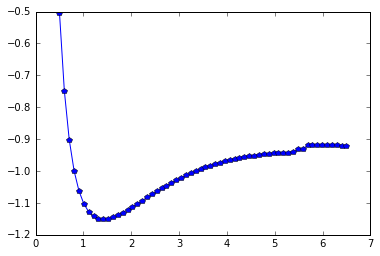

In [6]:
# fast non fancy plot
plt.plot(s_vector,avg, '-p')
plt.show()

In [7]:
# datablock
data_block_size = 100
def data_block(x):
    correct_length = len(x)-len(x)%data_block_size # make sure the list is an integer multiple of data_block_size
    xx = x[:correct_length].reshape(-1,data_block_size)
    avgs = np.mean(xx, axis = 0)
    var = np.std(xx,axis = 0)
    avg = np.mean(avgs, axis = 0)
    error = np.std(avgs)/np.sqrt(np.size(avgs))
    return avgs, var, avg, error

avg = np.zeros(int(N_s))
error = np.zeros(int(N_s))

for i in range(int(N_s)):
    avg[i] = data_block(E[:,i])[2]
    error[i] = data_block(E[:,i])[3]

# Fitting the data to the Morse potential and find the spectrum

In [9]:
r_e = s_min
def V(r, D_e, a, r_e, const):
    return D_e*(1.0-np.exp(-a*(r-r_e)))**2 + const

popt, pcov = curve_fit(V, s_vector, avg, maxfev=10000)

[D_e, a, r_e, const] = popt
print('D_e:', D_e, 'a:', a, 'r_e', r_e, 'minimum energy:', const)
print(np.sqrt(pcov.diagonal()))

# the spectrum
mu = 916.57
w_0 = a*np.sqrt(2*D_e/mu)
delta = D_e/w_0
v_max = int(2*D_e/w_0)
def e_v(v):
    return w_0*(v+0.5)-w_0**2/(4*D_e)*(v+0.5)**2+const

# find where to draw the lines for the spectrum
def roots(x):
    return V(x, D_e, a, r_e, const)-e_v(i)
def find_left():
    return brentq(roots, 0.0, r_e)
def find_right():
    return brentq(roots, r_e,1000)

D_e: 0.349708450087 a: 0.735882020509 r_e 1.61182703519 minimum energy: -1.16979204679
[ 0.0172305   0.03819248  0.04071281  0.01051653]


# The constants in units of cm$^{-1}$

In [12]:
from scipy import constants
#36117*6.63e-36*3e10/1.6e-19*27.2-1
Har = constants.physical_constants['Hartree energy in eV'][0]
print((D_e+1)/(constants.h*constants.c/constants.e*Har), 
      np.sqrt(pcov.diagonal()[0])/(constants.h*constants.c/constants.e*Har))

40005.8008431 510.717525502


# Morse potential with spectrum

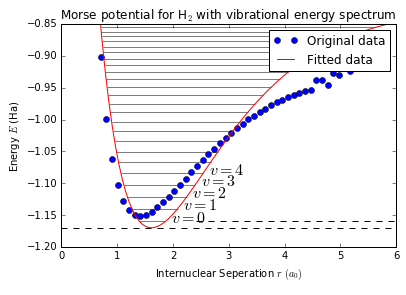

In [13]:
s_m = 6
plt.plot(s_vector,avg, 'bo', label='Original data')
long_s = np.linspace(0,s_m,100)
plt.plot(long_s, V(long_s, D_e, a, r_e, const), 'r-', label='Fitted data')
plt.title(r'Morse potential for H$_2$ with vibrational energy spectrum')
plt.ylim(-1.2,-0.85)
plt.xlim(0,s_m)
plt.xlabel(r'Internuclear Seperation $r$ $(a_0)$')
plt.ylabel(r'Energy $E$ (Ha)')
text_grote = 16
plt.hlines(const, 0, s_m, linestyles='dashed')
i = 0
plt.hlines(e_v(0), find_right()+0.55, s_m, linestyles='dashed')
plt.hlines(const+D_e, 0, s_m, linestyles='dashed')

for i in range(v_max):
    right = find_right()
    left = find_left()
    plt.hlines(e_v(i), left, right, linestyles='solid', alpha=0.5)
    if i < 5:
        plt.annotate(
            r'$v = %s$' %i, xy=(right+0.1, V(right, D_e, a, r_e, const)-.002), xycoords = 'data',
            xytext = (0, 0), textcoords = 'offset points', size=text_grote)

plt.annotate(
    '', xy=(1.2*s_max, const+D_e), xycoords = 'data',
    xytext = (1.2*s_max, const), textcoords = 'data',
    arrowprops = {'arrowstyle':'<->'})

plt.annotate(
    r'$D_e$', xy=(1.2*s_max, (y_min-y_max)/2+y_max), xycoords = 'data',
    xytext = (0, 0), textcoords = 'offset points', size=text_grote)

plt.annotate(
    '', xy=(1.1*s_max, const+D_e), xycoords = 'data',
    xytext = (1.1*s_max, e_v(0)), textcoords = 'data',
    arrowprops = {'arrowstyle':'<->'})

plt.annotate(
    r'$D_0$', xy=(1.1*s_max, (y_min-y_max)/2+y_max), xycoords = 'data',
    xytext = (0, 0), textcoords = 'offset points', size=text_grote)

plt.legend()
plt.show()